In [1]:
import sys
sys.path.append("..")

In [2]:
import matplotlib.pyplot as plt

In [3]:
from squlearn.qnn.loss import *
from squlearn.qnn.training import *
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [4]:
"""
from squlearn import Executor
from squlearn.encoding_circuit import ChebyshevRx, HubregtsenEncodingCircuit,YZ_CX_EncodingCircuit
from squlearn.observables import SummedPaulis
from squlearn.qnn import QNNClassifier, SquaredLoss, QNNRegressor, ODELoss
from squlearn.optimizers import *
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
"""

'\nfrom squlearn import Executor\nfrom squlearn.encoding_circuit import ChebyshevRx, HubregtsenEncodingCircuit,YZ_CX_EncodingCircuit\nfrom squlearn.observables import SummedPaulis\nfrom squlearn.qnn import QNNClassifier, SquaredLoss, QNNRegressor, ODELoss\nfrom squlearn.optimizers import *\nfrom sklearn.datasets import make_blobs\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import MinMaxScaler\nimport numpy as np\n'

In [5]:
from squlearn import Executor
from squlearn.encoding_circuit import ChebyshevRx, YZ_CX_EncodingCircuit
from squlearn.observables import SummedPaulis
from squlearn.qnn import QNNClassifier, QNNRegressor, SquaredLoss, ODELoss
from squlearn.optimizers import SLSQP
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [6]:
def L_functional(loss_values):
    x = loss_values["x"]
    f = loss_values["f"]
    dfdx = loss_values["dfdx"][:,0]
    dfdxdx = loss_values["dfdxdx"][:,0,0]
    value =  dfdx - np.cos(x)
    #insert initial value at last position of value
    #value = np.append(value, initial_value)
    return value

def grad_F_functional(loss_values):
    """ArithmeticError
    n = x_span.shape[0] number of points
    m = x_span.shape[1] number of dimensions (typically m=1)

    F[x, x_, x__] = envelope(x, x_, x__)

    grad_envelope = (envelope(x, x_, x__)dx, envelope(x, x_, x__)dx_, envelope(x, x_, x__)dx__)

    """
    x_span = loss_values["x"] # shape (n, m)   
    f = loss_values["f"] # shape (n,)
    dfdx = loss_values["dfdx"][:,0] # shape (n, m) 
    dfdxdx = loss_values["dfdxdx"][:,0,:] # shape (n, 1, m)

    dfdp = loss_values["dfdp"] # shape (n, p)
    n_param = dfdp.shape[1]
    #dfdpdx = loss_values["dfdpdx"][:,0,:] # shape (n, 1, p)
    #dfdpdxdx = loss_values["dfdpdxdx"][:,0,:] # shape (n, 1, 1, p)
    
    try:
        dfdxdp = loss_values["dfdxdp"] # shape (n, 1, P)
        dfdxdxdp = loss_values["dfdxdxdp"] # shape (n, 1, 1, P)
    except:
        dfdpdx = loss_values["dfdpdx"][:, :, 0] # shape (n, p, 1)
        dfdpdxdx = loss_values["dfdpdxdx"][:,:, 0, 0] # shape (n, p, 1, 1)

    #problem dependent gradient!!
    grad_envelope_list = np.zeros((3, x_span.shape[0], n_param)) # shape (3, n, p) 
    grad_envelope_list[0,:,:] = 0
    grad_envelope_list[1,:,:] = 1
    grad_envelope_list[2,:,:] = 0
    ###########3



    return grad_envelope_list

In [7]:
input_values = np.linspace(0, 4, 10)

In [8]:
input_values

array([0.        , 0.44444444, 0.88888889, 1.33333333, 1.77777778,
       2.22222222, 2.66666667, 3.11111111, 3.55555556, 4.        ])

In [9]:
num_qubits = 1
num_features = 1
num_layers = 4

initial_value = np.array([0])

"""clf_ODE = QNNRegressor(
    encoding_circuit = YZ_CX_EncodingCircuit(num_qubits, num_features, num_layers),
    operator = SummedPaulis(num_qubits),
    executor = Executor(),
    loss = ODELoss(L_functional, grad_F_functional, initial_vec = initial_value, eta=1),
    optimizer = SLSQP(),
    param_ini = np.random.rand(2*num_qubits*num_layers),
    param_op_ini = np.ones(num_qubits+1),
    opt_param_op = False
)
"""


'clf_ODE = QNNRegressor(\n    encoding_circuit = YZ_CX_EncodingCircuit(num_qubits, num_features, num_layers),\n    operator = SummedPaulis(num_qubits),\n    executor = Executor(),\n    loss = ODELoss(L_functional, grad_F_functional, initial_vec = initial_value, eta=1),\n    optimizer = SLSQP(),\n    param_ini = np.random.rand(2*num_qubits*num_layers),\n    param_op_ini = np.ones(num_qubits+1),\n    opt_param_op = False\n)\n'

In [10]:
loss = ODELoss(L_functional, grad_F_functional, initial_vec = initial_value, eta=1)
loss = SquaredLoss()
clf = QNNRegressor(
    YZ_CX_EncodingCircuit(num_qubits, num_features, num_layers),
    SummedPaulis(num_qubits),
    Executor("pennylane"),
    loss,
    SLSQP(),
    np.random.rand(2*num_qubits*num_layers),
    np.ones(num_qubits+1),
    opt_param_op = False
)

In [11]:
y = np.zeros((input_values.shape[0]))
clf._fit(input_values, y,  weights=None)

fit:   0%|          | 0/100 [00:00<?, ?it/s]Functional loss:  27.477744353854533
Initial value loss f:  0.755868482676726
Total:  28.233612836531258
dfdxdxdp shape:  (10, 1, 1, 8)
grad_envelope_list [[[0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]]

 [[1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1.]]

 [[0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0

KeyboardInterrupt: 

In [ ]:
dfdp shape:  (12, 16)
dfdpdx shape:  (12, 16, 1)
dfdpdxdx shape:  (12, 16, 1, 1)



dfdp shape:  (12, 16)
dfdxdp shape:  (12, 1, 16)
dfdxdxdp shape:  (12, 1, 1, 16)

In [ ]:
clf_ODE.predict(input_values)

array([-0.15719103, -0.03485702,  0.09964409,  0.22748242,  0.33785641,
        0.42799301,  0.49998125])

In [ ]:
clf_ODE.loss()

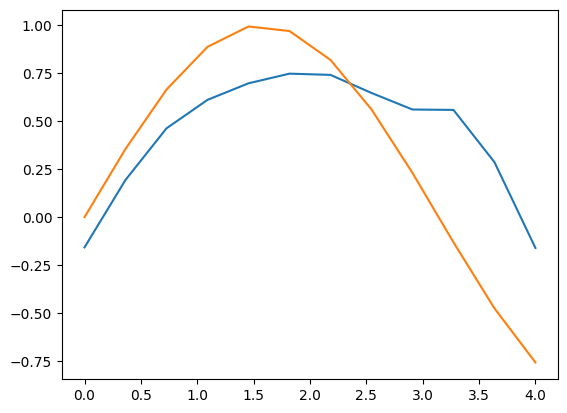

In [ ]:
plt.plot(input_values, clf_ODE.predict(input_values))
plt.plot(input_values, np.sin(input_values))

In [ ]:
from squlearn.qnn.base_qnn import QNN
num_qubits = 1
num_features = 1
num_layers = 3 


circuit = ChebyshevRx(num_qubits, num_features, num_layers)
observable = SummedPaulis(num_qubits) #observable.num_parameters = num_qubits+1
param_ini = np.random.rand(2*num_qubits*num_layers)
executor = Executor("statevector_simulator")

qnn_ = QNN(circuit, observable, executor, result_caching=False, optree_caching=False)

In [ ]:
input_values = np.array([  [0.1],[0.2]])
loss_values = qnn_.evaluate(("f", "dfdx", "dfdxdx", "dfdp", "dfdpdx", "dfdpdxdx"), input_values, param_ini, param_op_ini)

NameError: name 'param_op_ini' is not defined

In [ ]:
loss_values["dfdxdx"][:,0,0]

array([0.19317778, 0.22126637])

array([-0.16367608, -0.14300414])

In [ ]:
loss_values["f"]+loss_values["dfdxdx"]

array([[[0.40807955, 0.39272217]],

       [[0.43616814, 0.42081076]]])

In [ ]:
L_functional(loss_values)

{'f': array([[0.40807955, 0.39272217],
        [0.43616814, 0.42081076]])}

In [ ]:
loss_values["dfdp"].shape

(2, 4)

In [ ]:
def L_functional(loss_values, x_span):
    f = loss_values["f"]
    dfdx = loss_values["dfdx"] 
    dfdxdx = loss_values["dfdxdx"]
    value = dfdxdx + f #design your L functional here

    return {"f": value}

def grad_L_functional(loss_values, x_span):
    """ArithmeticError
    n = x_span.shape[0] number of points
    m = x_span.shape[1] number of dimensions (typically m=1)

    F[x, x_, x__] = envelope(x, x_, x__)

    grad_envelope = (envelope(x, x_, x__)dx, envelope(x, x_, x__)dx_, envelope(x, x_, x__)dx__)

    """
    f = loss_values["f"] # shape (n,)
    dfdx = loss_values["dfdx"] # shape (n, m) 
    dfdxdx = loss_values["dfdxdx"][:,0,:] # shape (n, 1, m)

    dfdp = loss_values["dfdp"] # shape (n, p)
    n_param = dfdp.shape[1]
    dfdpdx = loss_values["dfdpdx"][:,0,:] # shape (n, 1, p)
    dfdpdxdx = loss_values["dfdpdxdx"][:,0,0,:] # shape (n, 1, 1, p)
    
    #problem dependent gradient!!
    grad_envelope_list = np.zeros((3, x_span.shape[0], n_param)) # shape (3, n, p) 
    grad_envelope_list[0,:,:] = 1
    grad_envelope_list[1,:,:] = 0
    grad_envelope_list[2,:,:] = 1
    ###########3


    grad_p = np.array([dfdp, dfdpdx, dfdpdxdx])  # shape (n, p), (n, p), (n, p) -> (3, n, p)
    
    total_grad_einsum = np.einsum("ijk,ijk->jk", grad_envelope_list, grad_p) 
    #same as below
    #for n_i in range(x_span.shape[0]):
    #    for p_i in range(n_param):
    #        total_grad_[n_i, p_i] = np.sum(grad_envelope_list[:,n_i,p_i] * grad_p[:,n_i,p_i])
    #print(np.array_equal(total_grad_, total_grad_einsum))


    return {"dfdx": total_grad_einsum}

In [ ]:
#print squl

In [ ]:
num_qubits = 6
num_features = 1
num_layers = 3


circuit = ChebyshevRx(num_qubits, num_features, num_layers)
observable = SummedPaulis(num_qubits) #observable.num_parameters = num_qubits+1
param_ini = np.random.rand(2*num_qubits*num_layers)
param_op_ini = np.random.rand(num_qubits+1)
executor = Executor("statevector_simulator")

qnn_ = QNN(circuit, observable, executor, result_caching=False, optree_caching=False)

In [ ]:
def training_loss(optimization_parameters, X_train, qnn_, problem_parameters):
    param_ini, param_op_ini = optimization_parameters[:qnn_.num_parameters], optimization_parameters[qnn_.num_parameters:]
    g, f_initial, regularization_parameter = problem_parameters
    output_f = qnn_.evaluate("f", X_train, param_ini, param_op_ini)["f"]
    output_dfdx = qnn_.evaluate("dfdx", X_train, param_ini, param_op_ini)["dfdx"]
    return loss_function(output_f, output_dfdx, X_train, g, f_initial, regularization_parameter)

def loss_function(f_0, f_1, X, g, f_initial, regularization_parameter):
        """Calculates the loss function.

        f_0 = zeroth order derivative
        f_1 = first order derivative
        g = differential equation function
        Args:
            alpha_ (np.ndarray): The vector of alphas, of shape (len(x_span)+1, 

        """

        sum1 = np.sum( (f_1 - g(f_0, X))**2 )
        sum2 = (f_0[0] - f_initial)**2
        L = sum2 + sum1 * regularization_parameter
        print(L)
        return L

In [ ]:
def g_paper(f, x):
        """
        df/dx = -lamb * np.exp(-lamb * x * k) * np.sin(lamb * x) - lamb * k * f

        solution: f(x) = np.exp(-lamb * x * k) * np.cos(lamb * x), f(0) = 1
        """
        lamb = 20
        k = 0.1
        return -lamb * np.exp(-lamb * x * k) * np.sin(lamb * x) - lamb * k * f

In [ ]:
x_span = np.linspace(0.1, 0.9, 20)
f_initial = 1
g = g_paper

from scipy.integrate import odeint
from scipy.optimize import minimize
#Numerical and Analytical Solutions
f_odeint = odeint(g, f_initial, x_span[:])

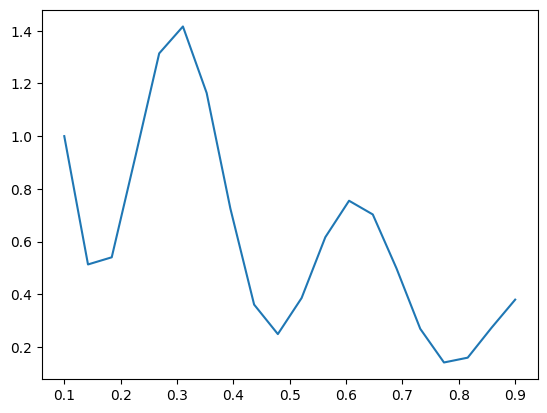

In [ ]:
plt.plot(x_span, f_odeint, label="Odeint")

In [ ]:
param_ini, param_op_ini = np.random.rand(2*num_qubits*num_layers), np.random.rand(num_qubits+1)
optimization_parameters_0 = np.concatenate((param_ini, param_op_ini))
f_initial = 1
regularization_parameter = 1
problem_parameters = (g_paper, f_initial, regularization_parameter)



result = minimize(training_loss, optimization_parameters_0, args=(x_span,
            qnn_, problem_parameters),
            options={'disp': True, 'maxiter': 10000})

18394.18050917232
18394.180494279433
18394.180509984133
18394.180504239055
18394.180522131628
18394.180507536854
18394.18050878806
18394.180478577426
18394.180509196147
18394.18049899365
18394.180526469278
18394.180503777498
18394.180508318655
18394.180501620485
18394.180510637536
18394.18050716893
18394.180509369082
18394.180513275838
18394.180508788064
18394.180494475408
18394.180510612347
18394.180506111603
18394.180509699894
18394.18051198598
18394.180508318652
18394.180512448434
18394.18050630663
18394.180509803475
18394.180512501563
18394.180507536854
18394.180508788064
18394.18051370344
18394.180500103295
18394.180511245504
18394.180511627805
18394.180503777498
18394.180508318652
18394.180556003623
18394.180519989266
18394.18052168439
18394.180520591053
18394.180517967347
18394.180515427503
18394.180509932146
17263.684077379752
17263.68407847517
17263.684075531393
17263.684080740833
17263.684070105
17263.68407850352
17263.684078002698
17263.684079021637
17263.68407519794
17263.6

KeyboardInterrupt: 

In [ ]:
solution = qnn_.evaluate("f", x_span, result.x[:qnn_.num_parameters], result.x[qnn_.num_parameters:])["f"]

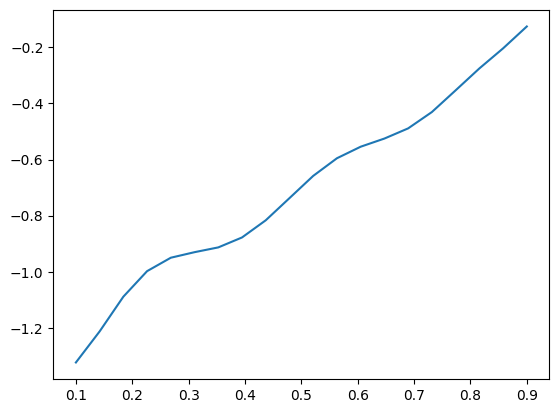

In [ ]:
plt.plot(x_span, solution, label="QNN")

In [ ]:
#QNN ODE solver 

# Calculate ground truth based on derivatives in the PINN sense (see already implemented with kernels)
# use partial_fit from qnn.qnnr.QNNRegressor, y_values will be calculated as above

# based on partial_fit, create new loss function that calculates the derivatives of the QNN

In [ ]:
def get_FQK_kernel_derivatives(self, x_array, qnn_, coef):
    """
    Get the FQK kernel and its derivatives for the given input data.

    Parameters:
    - x_array: The input data. np.array of shape (n, m) where n is the number of samples and m is the number of features.
    - qnn_: The FQK QNN.
    - coef: The coefficients of the P0 observable to be used in the QNN squlearn evaluation

    Returns:
    - output_f: The FQK kernel.
    - output_dfdx: The derivatives of the FQK kernel:  shape (n, n, m*2),  the last dimension is the derivative with respect to the input data. 
    """
    x_array = x_array.reshape(-1, 1) #reshape to column vector
    x_list_circuit_format = self.x_to_circuit_format(x_array)


    output_f = qnn_.evaluate("f", x_list_circuit_format, [], coef)["f"]
    output_dfdx = qnn_.evaluate("dfdx", x_list_circuit_format, [], coef)["dfdx"]
    

    #reshape the output to the shape of the gram matrix
    output_f = output_f.reshape((len(x_array), len(x_array)))
    output_dfdx = output_dfdx.reshape((len(x_array), len(x_array), len(x_array[0])*2))


    return output_f, output_dfdx

New squlearn

In [ ]:
from squlearn.qnn.lowlevel_qnn_base import LowLevelQNNBase
from squlearn.qnn.lowlevel_qnn_qiskit import LowLevelQNNQiskit

In [ ]:
        #qnn_ = BaseQNN(FQK_Circuit, P0_, self.executor, result_caching=False, optree_caching=False)


In [ ]:
encoding_circuit = ChebyshevRx(num_qubits, num_features, num_layers)
operator = SummedPaulis(num_qubits),
executor = Executor("statevector_simulator")
loss = SquaredLoss(),
optimizer = SLSQP(),
param_ini = np.random.rand(2*num_qubits*num_layers),
param_op_ini = np.random.rand(num_qubits+1)

In [ ]:
LowLevelQNNQiskit?

Init signature:
LowLevelQNNQiskit(
    parameterized_quantum_circuit: squlearn.encoding_circuit.encoding_circuit_base.EncodingCircuitBase,
    operator: Union[squlearn.observables.observable_base.ObservableBase, list],
    executor: squlearn.util.executor.Executor,
    optree_caching=True,
    result_caching=True,
) -> None
Docstring:     
Low level implementation of QNNs and its derivatives based on Qiskit.

Args:
    pqc (EncodingCircuitBase) : parameterized quantum circuit in encoding circuit format
    operator (Union[ObservableBase,list]): Operator that is used in the expectation
        value of the QNN. Can be a list for multiple outputs.
    executor (Executor) : Executor that is used for the evaluation of the QNN
    optree_caching : Caching of the optree expressions (default = True recommended)
    result_caching : Caching of the result for each `x`, `param`, `param_op` combination
        (default = True)

Attributes:
-----------

Attributes:
    num_qubits (int): Number of 

AttributeError: 'tuple' object has no attribute 'set_map'

In [ ]:
BaseQNN?

Init signature:
BaseQNN(
    encoding_circuit: 'EncodingCircuitBase',
    operator: 'Union[ObservableBase, list[ObservableBase]]',
    executor: 'Executor',
    loss: 'LossBase',
    optimizer: 'OptimizerBase',
    param_ini: 'Union[np.ndarray, None]' = None,
    param_op_ini: 'Union[np.ndarray, None]' = None,
    batch_size: 'int' = None,
    epochs: 'int' = None,
    shuffle: 'bool' = None,
    opt_param_op: 'bool' = True,
    variance: 'Union[float, Callable]' = None,
    shot_control: 'ShotControlBase' = None,
    parameter_seed: 'Union[int, None]' = 0,
    caching: 'bool' = True,
    pretrained: 'bool' = False,
    callback: 'Union[Callable, str, None]' = None,
    **kwargs,
) -> 'None'
Docstring:     
Base Class for Quantum Neural Networks.

Args:
    encoding_circuit : Parameterized quantum circuit in encoding circuit format
    operator : Operator that are used in the expectation value of the QNN. Can be a list for
        multiple outputs.
    executor : Executor instance
    

In [ ]:
def get_FQK_kernel_derivatives(self, x_array, qnn_, coef):
        """
        Get the FQK kernel and its derivatives for the given input data.

        Parameters:
        - x_array: The input data. np.array of shape (n, m) where n is the number of samples and m is the number of features.
        - qnn_: The FQK QNN.
        - coef: The coefficients of the P0 observable to be used in the QNN squlearn evaluation

        Returns:
        - output_f: The FQK kernel.
        - output_dfdx: The derivatives of the FQK kernel:  shape (n, n, m*2),  the last dimension is the derivative with respect to the input data. 
        """
        

        x_array = x_array.reshape(-1, 1) #reshape to column vector
        x_list_circuit_format = self.x_to_circuit_format(x_array)


        output_f = qnn_.evaluate("f", x_list_circuit_format, [], coef)["f"]
        output_dfdx = qnn_.evaluate("dfdx", x_list_circuit_format, [], coef)["dfdx"]
        

        #reshape the output to the shape of the gram matrix
        output_f = output_f.reshape((len(x_array), len(x_array)))
        output_dfdx = output_dfdx.reshape((len(x_array), len(x_array), len(x_array[0])*2))


        return output_f, output_dfdx

In [ ]:
#QNN ODE solver 

# Calculate ground truth based on derivatives in the PINN sense (see already implemented with kernels)
# use partial_fit from qnn.qnnr.QNNRegressor, y_values will be calculated as above

# based on partial_fit, create new loss function that calculates the derivatives of the QNN